<a href="https://colab.research.google.com/github/42697387/Aprendizaje-Automatico-2/blob/main/2025_AA2_TP3_desafio_imagenes_original.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Trabajo Práctico Evaluativo: Clasificación de Imágenes con PyTorch, redes convolucionales y transfer learning

## Objetivos
Este trabajo práctico tiene como objetivo evaluar su capacidad para:
- Implementar un data loader personalizado en PyTorch
- Diseñar e implementar redes neuronales convolucionales
- Entrenar y evaluar modelos de aprendizaje profundo
- Documentar adecuadamente el proceso y resultados de cada consigna.

## Clasificador de Perros y Gatos con CNN

### Datos
Utilice el dataset "Cats and Dogs" de Microsoft disponible en el siguiente enlace:
[https://www.microsoft.com/en-us/download/details.aspx?id=54765](https://www.microsoft.com/en-us/download/details.aspx?id=54765)




## **1. Preprocesamiento y Data Loader. [JUAN IGNACIO HILLIARD BOCHACA]**

- 1.1 Descargue y descomprima el dataset.
- 1.2 Implemente su propio data loader personalizado (clases `Dataset` y `DataLoader`).
- 1.2.1 Incluya transformaciones apropiadas (redimensionamiento, normalización).
- 1.2.2 Divida los datos en conjuntos de entrenamiento, validación y prueba (sugerencia: 70%, 15%, 15%).
- 1.3 Realice una exploración inicial de los datos (distribución de clases, dimensiones de las imágenes, etc.).





# Trabajo Práctico Evaluativo: Clasificador Perros vs Gatos con PyTorch
**Nombre de quien resuelve:** JUAN IGNACIO HILLIARD BOCHACA
**Objetivo:** Implementar preprocesamiento y DataLoader personalizado en PyTorch; realizar exploración inicial de datos; preparar splits (train/val/test).  
**Dataset:** `kagglecatsanddogs_5340.zip` (Microsoft download link)



# Descargar y descomprimir el dataset
Esta celda descarga el archivo .zip desde la URL proporcionada usando wget, lo descomprime con unzip y crea una ruta base (data_dir) apuntando a la carpeta PetImages que contiene las subcarpetas Cat y Dog. Además verifica que las carpetas existen y muestra el número de archivos por carpeta (solo cuenta archivos, ignora subdirectorios ocultos). Incluye manejo básico de errores para descargar y descomprimir. Está pensado para Colab — usa ! para comandos de shell.

In [ ]:
import os
import random
import numpy as np
from PIL import Image
from collections import Counter
import matplotlib.pyplot as plt

import torch
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms

# Para split estratificado
from sklearn.model_selection import train_test_split

# DESCARGA Y DESCOMPRIME DATASET
# Explicación resumida: descarga el zip y lo descomprime en /content/data

# Ejecutar en Google Colab
!mkdir -p /content/data
DATA_ZIP_URL = "https://download.microsoft.com/download/3/e/1/3e1c3f21-ecdb-4869-8368-6deba77b919f/kagglecatsanddogs_5340.zip"
ZIP_PATH = "/content/data/kagglecatsanddogs_5340.zip"
DATA_DIR = "/content/data/PetImages"  # ruta que se espera dentro del zip

# Descargar si no existe
if not os.path.exists(ZIP_PATH):
    print("Descargando dataset... (tarda unos minutos según conexión)")
    !wget -q -O "{ZIP_PATH}" "{DATA_ZIP_URL}"
else:
    print("Zip ya presente, saltando descarga.")

# Descomprimir
print("Descomprimiendo...")
!unzip -q -o "{ZIP_PATH}" -d /content/data

# Verificar estructura
import os
for cls in ["Cat", "Dog"]:
    cls_dir = os.path.join(DATA_DIR, cls)
    if os.path.exists(cls_dir):
        n_files = len([f for f in os.listdir(cls_dir) if os.path.isfile(os.path.join(cls_dir, f))])
        print(f"{cls_dir}: {n_files} archivos")
    else:
        print(f"Advertencia: no existe la carpeta esperada: {cls_dir}")

# Mostrar primera lista de archivos para confirmación rápida
print("\nEjemplos de cada clase:")
for cls in ["Cat", "Dog"]:
    cls_dir = os.path.join(DATA_DIR, cls)
    if os.path.exists(cls_dir):
        print(f"\n{cls}:")
        print("\n".join(os.listdir(cls_dir)[:5]))

Descargando dataset... (tarda unos minutos según conexión)
Descomprimiendo...
/content/data/PetImages/Cat: 12501 archivos
/content/data/PetImages/Dog: 12501 archivos

Ejemplos de cada clase:

Cat:
9339.jpg
1429.jpg
8467.jpg
11520.jpg
1599.jpg

Dog:
9339.jpg
1429.jpg
8467.jpg
11520.jpg
1599.jpg


# Imports, configuración y semillas
Importa librerías necesarias: torch, torchvision, PIL, sklearn para el split estratificado, matplotlib para gráficas y utilidades estándar. Fija una semilla global para reproducibilidad (impacta numpy, random, torch), y configura device (detecta GPU en Colab). También define NUM_WORKERS y PIN_MEMORY

In [ ]:
SEED = 42
random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

# Device y parámetros DataLoader
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
NUM_WORKERS = 4 if torch.cuda.is_available() else 0
PIN_MEMORY = True if torch.cuda.is_available() else False

print(f"Device: {device}, NUM_WORKERS: {NUM_WORKERS}, PIN_MEMORY: {PIN_MEMORY}")

Device: cuda, NUM_WORKERS: 4, PIN_MEMORY: True


# Construcción de lista de rutas y etiquetas
Esta celda recorre las carpetas PetImages/Cat y PetImages/Dog, toma todos los archivos que parecen imágenes (por extensión), crea una lista de rutas y una lista paralela de etiquetas numéricas (0=cat, 1=dog). Además detecta y registra archivos que no se puedan abrir con PIL (posibles corruptos) y los excluye — esto es importante porque en este dataset hay imágenes corruptas. Devuelve un DataFrame (pandas) con columnas path y label que facilitará la división estratificada.

In [ ]:
# CREAR LISTA DE RUTAS Y ETIQUETAS (EXCLUYENDO ARCHIVOS CORRUPTOS)
# Explicación: lista todos los archivos, intenta abrirlos con PIL y descarta los corruptos.

import pandas as pd

data_dir = "/content/data/PetImages"
classes = {"Cat": 0, "Dog": 1}

paths = []
labels = []
bad_files = []

for cls_name, cls_idx in classes.items():
    cls_dir = os.path.join(data_dir, cls_name)
    if not os.path.exists(cls_dir):
        raise FileNotFoundError(f"No se encontró la carpeta esperada: {cls_dir}")
    for fname in os.listdir(cls_dir):
        fpath = os.path.join(cls_dir, fname)
        if not os.path.isfile(fpath):
            continue
        # filtrar extensiones comunes
        if not fname.lower().endswith((".jpg", ".jpeg", ".png", ".bmp")):
            continue
        # intentar abrir para detectar corruptos
        try:
            with Image.open(fpath) as im:
                im.verify()  # detecta corrupción en la cabecera
        except Exception as e:
            bad_files.append(fpath)
            continue
        paths.append(fpath)
        labels.append(cls_idx)

print(f"Total imágenes válidas: {len(paths)}")
print(f"Archivos corruptos ignorados: {len(bad_files)}")

df = pd.DataFrame({"path": paths, "label": labels})
df.head()

/usr/local/lib/python3.12/dist-packages/PIL/TiffImagePlugin.py:950: UserWarning: Truncated File Read
  warnings.warn(str(msg))


Total imágenes válidas: 24998
Archivos corruptos ignorados: 2


path  label
0   /content/data/PetImages/Cat/9339.jpg      0
1   /content/data/PetImages/Cat/1429.jpg      0
2   /content/data/PetImages/Cat/8467.jpg      0
3  /content/data/PetImages/Cat/11520.jpg      0
4   /content/data/PetImages/Cat/1599.jpg      0

# División estratificada en train/val/test (70/15/15)

Usamos sklearn.model_selection.train_test_split con stratify para conservar la proporción de clases en cada partición. Primero se separa train (70%) y temp (30%), luego temp se divide en val y test en proporción 50/50 de temp (cada una 15% del total). Fija la semilla random_state para reproducibilidad. Al final imprime tamaños y la distribución de clases por partición.

In [ ]:
# SPLIT ESTRATIFICADO 70/15/15
# Explicación: split estratificado en dos pasos para asegurar proporciones de clase

train_df, temp_df = train_test_split(df, test_size=0.30, stratify=df["label"], random_state=SEED)
val_df, test_df = train_test_split(temp_df, test_size=0.5, stratify=temp_df["label"], random_state=SEED)

print("Tamaños de particiones:")
print(f"Train: {len(train_df)}")
print(f"Validation: {len(val_df)}")
print(f"Test: {len(test_df)}")

def show_dist(name, dataframe):
    c = Counter(dataframe["label"])
    print(f"{name} -> cats: {c.get(0,0)}, dogs: {c.get(1,0)}")

show_dist("Train", train_df)
show_dist("Validation", val_df)
show_dist("Test", test_df)


Tamaños de particiones:
Train: 17498
Validation: 3750
Test: 3750
Train -> cats: 8749, dogs: 8749
Validation -> cats: 1875, dogs: 1875
Test -> cats: 1875, dogs: 1875


# Transformaciones (train / val/test) — redimensionamiento y normalización
Define transformaciones recomendadas: para entrenamiento usamos transforms.RandomResizedCrop para aumentos, RandomHorizontalFlip y ColorJitter (ligero) — esto ayuda a generalizar. Para validación y test usamos transforms.Resize seguido de CenterCrop para determinismo. Convertimos a tensor y normalizamos con la media/STD de ImageNet (mean=[0.485..], std=[0.229..]) porque es estándar cuando se usa transfer learning

In [ ]:
# TRANSFORMACIONES
# Explicación: transformaciones separadas para train/val/test; normalización con stats de ImageNet

IMG_SIZE = 224  # tamaño objetivo (común para modelos preentrenados)

train_transforms = transforms.Compose([
    transforms.RandomResizedCrop(IMG_SIZE, scale=(0.8, 1.0)),
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.02),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

val_test_transforms = transforms.Compose([
    transforms.Resize(int(IMG_SIZE * 1.14)),  # pequeño sobre-escalado para luego recorte centrado
    transforms.CenterCrop(IMG_SIZE),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

# Implementación del Dataset personalizado (PyTorch Dataset)
Creamos una clase CatsDogsDataset que hereda de torch.utils.data.Dataset. En __init__ se recibe un DataFrame (path + label) y una transformación. En __getitem__ abrimos la imagen con PIL en modo RGB, aplicamos la transformación y devolvemos un tensor y el label como torch.long. Incluye manejo para imágenes que puedan fallar en tiempo de carga (reintenta o lanza excepción con ruta para debug). La implementación es clara y documentada — ideal para la entrega.

In [ ]:
# DATASET PERSONALIZADO
# Explicación: Dataset que recibe un dataframe con columnas path y label y aplica transforms al vuelo.

class CatsDogsDataset(Dataset):
    def __init__(self, df, transform=None):
        """
        Args:
            df (pd.DataFrame): dataframe con columnas 'path' y 'label'
            transform (callable, optional): transform to apply to PIL image
        """
        self.df = df.reset_index(drop=True)
        self.transform = transform

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        row = self.df.iloc[idx]
        img_path = row["path"]
        label = int(row["label"])
        try:
            img = Image.open(img_path).convert("RGB")
        except Exception as e:
            # En caso de error, reportar ruta para depuración
            raise RuntimeError(f"Error al abrir imagen {img_path}: {e}")

        if self.transform:
            img = self.transform(img)

        return img, torch.tensor(label, dtype=torch.long)

# Prueba rápida del dataset
sample_ds = CatsDogsDataset(train_df.iloc[:8], transform=val_test_transforms)
x, y = sample_ds[0]
print("Ejemplo tensor shape:", x.shape, "label:", y)


Ejemplo tensor shape: torch.Size([3, 224, 224]) label: tensor(1)


# Creación de DataLoaders (train/val/test)
Se crean DataLoaders para cada partición con batch_size configurable. train usa shuffle=True. num_workers y pin_memory se ajustan según device. También imprimo el tamaño del batch y una muestra rápida de shapes para validar que todo funciona correctamente. Incluyo drop_last=False para mantener todas las muestras en evaluación.

In [ ]:
# DATALOADERS
# Explicación: crear DataLoaders listos para entrenamiento y evaluación

BATCH_SIZE = 32

train_dataset = CatsDogsDataset(train_df, transform=train_transforms)
val_dataset = CatsDogsDataset(val_df, transform=val_test_transforms)
test_dataset = CatsDogsDataset(test_df, transform=val_test_transforms)

train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True,
                          num_workers=NUM_WORKERS, pin_memory=PIN_MEMORY, drop_last=False)
val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False,
                        num_workers=NUM_WORKERS, pin_memory=PIN_MEMORY, drop_last=False)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False,
                         num_workers=NUM_WORKERS, pin_memory=PIN_MEMORY, drop_last=False)

# Comprobación rápida
for imgs, labels in train_loader:
    print("Batch train -> imgs:", imgs.shape, "labels:", labels.shape)
    break


/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:627: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


Batch train -> imgs: torch.Size([32, 3, 224, 224]) labels: torch.Size([32])


# Exploración inicial de los datos: distribución de clases y tamaños de imagen
Analiza la distribución de clases en el conjunto global y por partición (ya vimos los conteos, pero aquí lo grafico). Además recorro una muestra de imágenes para obtener las dimensiones reales (width x height) antes de las transformaciones — muchas imágenes en este dataset vienen en tamaños variados. Grafico un histograma de áreas o mayores dimensiones para que tu profesora vea la variabilidad. También muestro 6 imágenes de ejemplo (3 de cada clase) usando matplotlib (antes de normalizar) para inspección visual.

Distribución global (0=cat,1=dog): Counter({0: 12499, 1: 12499})


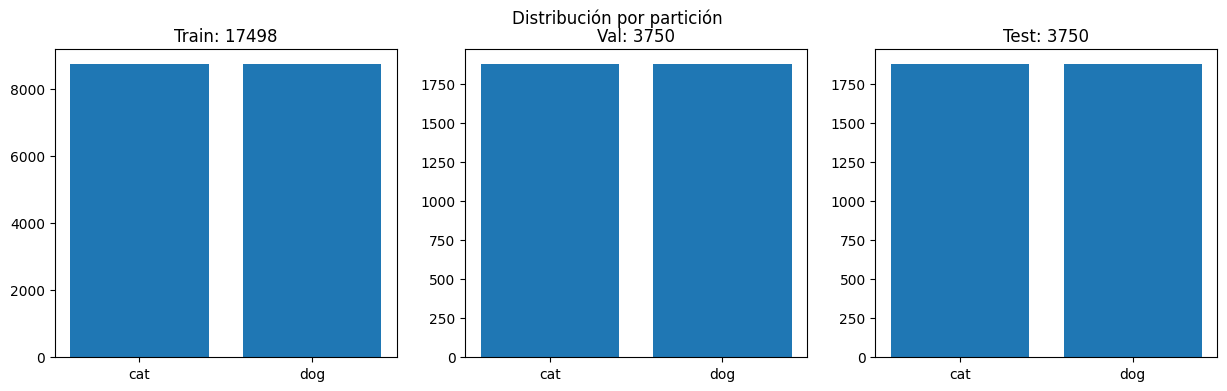

Muestras de dimensiones (n=1000): width mean=406.4, height mean=360.9


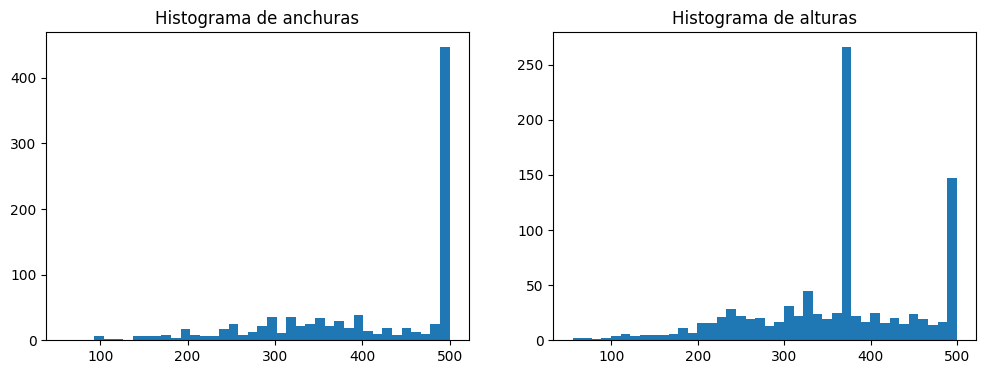

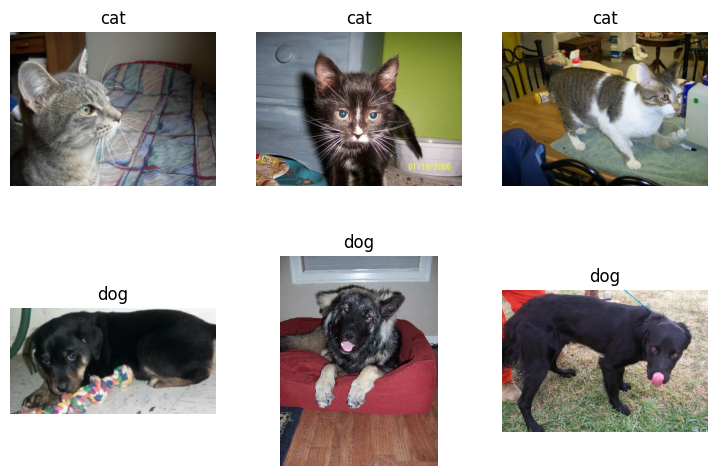

In [ ]:
import matplotlib.pyplot as plt

# Distribución global
global_counts = Counter(df["label"])
print("Distribución global (0=cat,1=dog):", global_counts)

# Graficar distribución por partición
fig, ax = plt.subplots(1, 3, figsize=(15,4))
for i, (name, dataframe) in enumerate([("Train", train_df), ("Val", val_df), ("Test", test_df)]):
    cnt = Counter(dataframe["label"])
    ax[i].bar(["cat","dog"], [cnt.get(0,0), cnt.get(1,0)])
    ax[i].set_title(f"{name}: {len(dataframe)}")
plt.suptitle("Distribución por partición")
plt.show()

# Medir tamaños originales (muestreo para eficiencia)
sample_paths = df["path"].sample(n=min(1000, len(df)), random_state=SEED).tolist()
widths = []
heights = []
for p in sample_paths:
    try:
        with Image.open(p) as im:
            w,h = im.size
            widths.append(w)
            heights.append(h)
    except:
        continue

print(f"Muestras de dimensiones (n={len(widths)}): width mean={np.mean(widths):.1f}, height mean={np.mean(heights):.1f}")
fig, ax = plt.subplots(1,2,figsize=(12,4))
ax[0].hist(widths, bins=40)
ax[0].set_title("Histograma de anchuras")
ax[1].hist(heights, bins=40)
ax[1].set_title("Histograma de alturas")
plt.show()

# Mostrar ejemplos (antes de transforms)
def show_images(paths, titles=None, ncols=3):
    n = len(paths)
    nrows = (n + ncols - 1) // ncols
    plt.figure(figsize=(ncols*3, nrows*3))
    for i,p in enumerate(paths):
        try:
            img = Image.open(p).convert("RGB")
        except:
            continue
        plt.subplot(nrows, ncols, i+1)
        plt.imshow(img)
        plt.axis("off")
        if titles:
            plt.title(titles[i])
    plt.show()

# seleccionar ejemplos: 3 cats + 3 dogs
cat_examples = train_df[train_df["label"]==0]["path"].sample(3, random_state=SEED).tolist()
dog_examples = train_df[train_df["label"]==1]["path"].sample(3, random_state=SEED).tolist()
show_images(cat_examples + dog_examples, titles=["cat"]*3 + ["dog"]*3, ncols=3)

# Referencias
-Prompt a ChatGPT: Explicame pas a paso como implementar estas consignas en google colab

-Clases Previas de la materia

-Implementación de clases Dataset y DataLoader

PyTorch Documentation. (2024). torch.utils.data — Data loading utilities.
URL: https://pytorch.org/docs/stable/data.html

## **2. Data Augmentation. [SOFIA ANTONIA GAMALLO:]**
- 2.1 Investigue y seleccione 3-4 técnicas de *Data Augmentation* apropiadas para este dataset (ej. rotaciones, flips horizontales, zoom, etc.).
- 2.2 Cree un nuevo conjunto de transformaciones de *entrenamiento* que incluya estas técnicas.
- 2.3 Asegúrese de que las transformaciones de *validación* y *prueba* **no** incluyan augmentation (solo redimensionamiento y normalización).
- 2.4 Actualice el `DataLoader` de entrenamiento para usar estas nuevas transformaciones.


### 2.1 Técnicas de Data Augmentation

Para el primer punto investigué en la página de documentación de pytorch todas las tranformaciones disponibles (https://docs.pytorch.org/vision/main/transforms.html) y le pregunté a ChatGPT cuáles eran las más indicadas para una clasificación de imágenes con redes CNN. Me dió las siguientes:

* RandomResizedCrop: Recorta una porción aleatoria de la entrada y redimensiona a un tamaño determinado.

* RamdonHorizontalFlip: Invierte la imágen horizontal a lateral.

* ColorJitter: Cambia aleatoriamente el brillo, el contraste, la saturación y el tono de una imagen o vídeo.

Ya que estas técnicas se implementaron en el punto 1, voy a agregar 3 más:

* RandomRotation: Gira la imágen por ángulo.

* RandomAffine: Transformación afín aleatoria que mantiene la entrada invariante en el centro.

* RandomErasing: Selecciona aleatoriamente una región rectangular en la imagen o vídeo de entrada y borra sus píxeles.

Estas técnicas se complementan bien con las 3 anteriores y ayudan a reducir el riesgo de sobreajuste.

In [ ]:
# 2.2 Se agregan las 6 tranformaciones en el train:

train_transforms = transforms.Compose([
    transforms.RandomResizedCrop(IMG_SIZE, scale=(0.8, 1.0)),
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2),
    transforms.RandomRotation(degrees=15),
    transforms.RandomAffine(degrees=10, translate=(0.05, 0.05), scale=(0.9, 1.1)),
    transforms.ToTensor(),
    transforms.RandomErasing(p=0.25),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                         std=[0.229, 0.224, 0.225]),
])

# 2.3 Asegurar que la validación y prueba no incluyan las tranformaciones:

val_test_transforms = transforms.Compose([
    transforms.Resize(int(IMG_SIZE * 1.14)),
    transforms.CenterCrop(IMG_SIZE),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                         std=[0.229, 0.224, 0.225]),
])

# 2.4 Actualizar el DtaLoader para usar las nuevas tranformaciones:

train_dataset = CatsDogsDataset(train_df, transform=train_transforms)
train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True,
                          num_workers=NUM_WORKERS, pin_memory=PIN_MEMORY, drop_last=False)

# Recrear también la validación y la prueba para asegurar consistencia
val_dataset = CatsDogsDataset(val_df, transform=val_test_transforms)
val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False,
                        num_workers=NUM_WORKERS, pin_memory=PIN_MEMORY, drop_last=False)

test_dataset = CatsDogsDataset(test_df, transform=val_test_transforms)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False,
                         num_workers=NUM_WORKERS, pin_memory=PIN_MEMORY, drop_last=False)

### Visualización del Data Augmentation

Para verificar que las tranformaciones se hicieron correctamente voy a visualizar 12 imágenes aleaotiras, 6 originales del dataset sin tranformar, y 6 tranformadas:

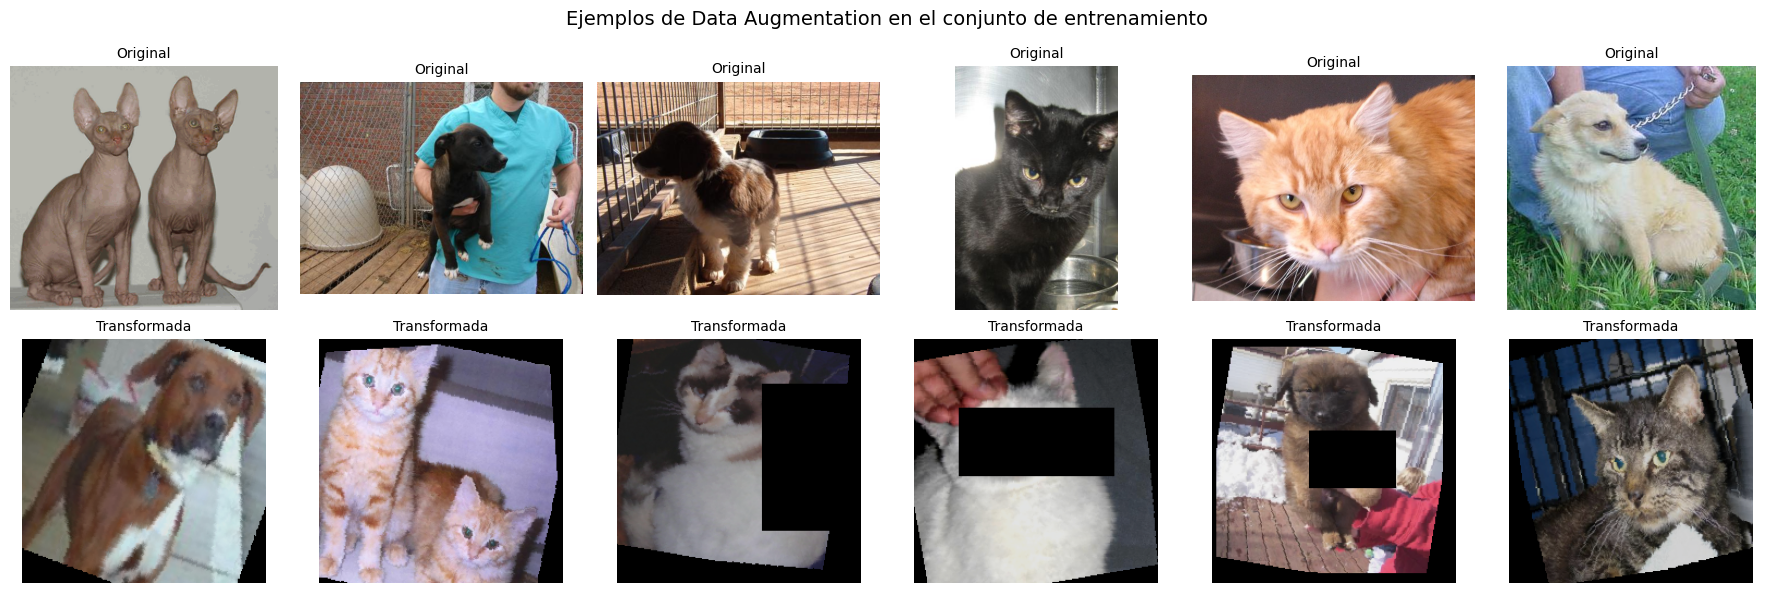

In [ ]:
# Seleccionar algunas imágenes del dataset original

sample_paths = train_df["path"].sample(6, random_state=42).tolist()
def imshow_tensor(tensor_img):
    """Convierte un tensor normalizado en una imagen visible."""
    img = tensor_img.clone().detach().cpu().numpy().transpose(1, 2, 0)
    img = np.clip(img * np.array([0.229, 0.224, 0.225]) + np.array([0.485, 0.456, 0.406]), 0, 1)
    return img

# Mostrar imágenes originales y transformadas lado a lado

fig, axes = plt.subplots(2, 6, figsize=(18, 6))
fig.suptitle("Ejemplos de Data Augmentation en el conjunto de entrenamiento", fontsize=14)
for i, path in enumerate(sample_paths):
    # Original
    img_orig = Image.open(path).convert("RGB")
    axes[0, i].imshow(img_orig)
    axes[0, i].set_title("Original", fontsize=10)
    axes[0, i].axis("off")

    # Transformada
    img_aug, _ = train_dataset[i]  # toma imagen con la tranformacion aplicada
    axes[1, i].imshow(imshow_tensor(img_aug))
    axes[1, i].set_title("Transformada", fontsize=10)
    axes[1, i].axis("off")

plt.tight_layout()
plt.show()

### **Referencias:**

* Página de la documentación oficial de Pytorch para investigar todas las tranformaciones posibles: https://docs.pytorch.org/vision/main/transforms.html
* Prompt de ChatGPT para seleccionar las mejores tranformaciones: Cual de todas estas tranformaciones son las adecuadas para un modelo de clasificacion de imágenes usando redes CNN: https://docs.pytorch.org/vision/main/transforms.html?

## **3. Arquitectura de la Red (CNN desde Cero). JORGE FLORES**
(Consigna original 2)
- 3.1 Diseñe una red neuronal convolucional para la clasificación binaria (perros vs gatos).
- 3.2 La arquitectura debe utilizar exclusivamente capas convolucionales y fully-connected.
- 3.3 Implemente correctamente el `forward pass` de la red.
- 3.4 Justifique las decisiones de diseño (número de capas, filtros, activaciones, etc.).

**Nombre de quien resuelve: JORGE FLORES**

In [ ]:
import torch.nn as nn

class CNNBinaryClassifier_Lite(nn.Module):
    def __init__(self):
        super().__init__()

        # Bloques convolucionales
        self.conv_layers = nn.Sequential(
            nn.Conv2d(3, 16, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2, 2),

            nn.Conv2d(16, 32, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2, 2),

            nn.Conv2d(32, 64, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2, 2)
        )

        # Capas fully-connected
        self.fc_layers = nn.Sequential(
            nn.Flatten(),
            # The linear layer input size will be determined after inspecting the flattened shape
            # during a forward pass.
            nn.Linear(64 * 28 * 28, 128),
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(128, 1)
        )

    def forward(self, x):
        x = self.conv_layers(x)
        # Add print statement to inspect the shape after flattening
        # print("Shape after conv layers:", x.shape)
        # print("Shape after flattening:", nn.Flatten()(x).shape)
        x = self.fc_layers(x)
        return x


# Instanciamos el modelo
model = CNNBinaryClassifier_Lite().to(device)

# **Explicacion de la arquitectura usada**

La red se diseñó con el objetivo de lograr un buen equilibrio entre **rendimiento y simplicidad**, utilizando exclusivamente capas **convolucionales** y **fully-connected**.

- Se emplean **tres capas convolucionales** para que el modelo aprenda progresivamente características más complejas de las imágenes (bordes, formas, patrones).  
- Los **filtros aumentan (16, 32, 64)** a medida que se avanza, permitiendo capturar información más detallada sin sobrecargar el modelo.  
- El **kernel 3×3** es el estándar en visión por computadora y permite conservar detalles locales.  
- **MaxPooling (2×2)** reduce el tamaño de las imágenes, disminuye el costo computacional y mejora la generalización.  
- La función de activación **ReLU** se utiliza por su eficiencia y porque evita problemas con los gradientes.  
- En la parte final, las **capas fully-connected** combinan las características extraídas y realizan la clasificación.  
- Se incluye un **Dropout(0.5)** para evitar el sobreajuste y mejorar la capacidad de generalización del modelo.  
- La **última capa** tiene una sola neurona, ya que el problema es de **clasificación binaria (perros vs gatos)**.

En resumen, es una **arquitectura liviana, eficiente y fácil de entrenar.**

## REFERENCIAS

### PROMPT GPT


> ```
> Explicá las mejoras aplicadas a mi CNN para clasificación binaria, indicando brevemente por qué mejoran el modelo.
> Usá solo capas convolucionales y fully-connected.



- **PyTorch – Conv2d:**  
  [https://docs.pytorch.org/docs/stable/generated/torch.nn.Conv2d.html](https://docs.pytorch.org/docs/stable/generated/torch.nn.Conv2d.html)

- **Apuntes de clase.**  





## **4. Entrenamiento (CNN desde Cero). [MELISA SABRINA GUREVICH]**

- 4.1 Configure los hiperparámetros del entrenamiento (learning rate, batch size, número de épocas, etc.).
- 4.2 Seleccione una función de pérdida (ej. `BCEWithLogitsLoss`) y un optimizador (ej. `Adam`).
- 4.3 Implemente el bucle de entrenamiento completo, incluyendo el bucle de validación por época.
- 4.4 Registre las métricas de *loss* y *accuracy* de entrenamiento y validación por época.

**Nombre de quien resuelve: Melisa Sabrina Gurevich**

### 4.1 Configuración de Hiperparámetros

- En este paso dejamos configurado el entorno de entrenamiento: definimos usar 10 épocas, que es un número prudente ya que permite que el modelo aprenda bien sin tardar tanto ni sobreajustar, especialmente porque todavía no aplicamos Early Stopping.

In [ ]:
# Configuración de Hiperparámetros

EPOCHS = 10              # suficiente para tu baseline sin early stopping
LR = 1e-3                # learning rate
WEIGHT_DECAY = 1e-4      # regularización L2
GRAD_CLIP = 1.0          # clipping para estabilidad

import torch
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = model.to(device)   # <-- tu modelo ya definido antes


In [ ]:
# Ajuste de la cabeza fully-connected para 128x128 (3 MaxPool -> 16x16)
model.fc_layers = nn.Sequential(
    nn.Flatten(),
    nn.Linear(64 * 16 * 16, 128),  # antes 64*28*28
    nn.ReLU(),
    nn.Dropout(0.5),
    nn.Linear(128, 1)
)

# Recrear el optimizador porque cambió model.parameters()
optimizer = torch.optim.Adam(model.parameters(), lr=LR, weight_decay=WEIGHT_DECAY)


### 4.2 Función de Pérdida y Optimizador

- Seleccionamos la función de pérdida BCEWithLogitsLoss, adecuada para clasificación binaria, y utilizamos Adam como optimizador por su buen rendimiento en CNN. Además, aplicamos un scheduler (StepLR) para reducir progresivamente la tasa de aprendizaje y así mejorar la convergencia del modelo durante las épocas.

In [ ]:
# Pérdida, Optimizador y Scheduler (con cabeza adaptable)

import torch.nn as nn
import torch.optim as optim
from torch.optim.lr_scheduler import StepLR

# Cabeza adaptable: funciona igual con 128x128 o 224x224
model.fc_layers = nn.Sequential(
    nn.AdaptiveAvgPool2d((1, 1)),  # -> (B, 64, 1, 1) si tu último bloque tiene 64 canales
    nn.Flatten(),                  # -> (B, 64)
    nn.Linear(64, 128),
    nn.ReLU(),
    nn.Dropout(0.5),
    nn.Linear(128, 1)
).to(device)

criterion = nn.BCEWithLogitsLoss()                  # binaria, sin sigmoid explícito
optimizer = optim.Adam(model.parameters(), lr=LR, weight_decay=WEIGHT_DECAY)

# Con pocas épocas conviene step_size corto para que reduzca LR al menos una vez
scheduler = StepLR(optimizer, step_size=3, gamma=0.5)


### 4.3 Implementación del Bucle de Entrenamiento y Validación

- Implementamos el ciclo que entrena y evalúa el modelo en cada época. En la fase de entrenamiento se ajustan los pesos mediante backpropagation, y en la fase de validación solo se mide el rendimiento sin actualizar parámetros. En cada época registramos la pérdida (loss) y la exactitud (accuracy) para observar cómo evoluciona el aprendizaje

In [ ]:
# Entrenamiento + Validación

from collections import defaultdict

# Limitar batches por época para acelerar (None = usar todos)
MAX_TRAIN_BATCHES = 80
MAX_VAL_BATCHES   = 30

history = defaultdict(list)

def batch_accuracy(logits, targets):
    probs = torch.sigmoid(logits.view(-1))
    preds = (probs >= 0.5).long()
    return (preds == targets).float().mean().item()

for epoch in range(1, EPOCHS + 1):
    # ===== Entrenamiento =====
    model.train()
    tr_loss = tr_acc = 0.0
    n_tr = 0

    for b, (imgs, labels) in enumerate(train_loader, start=1):
        imgs   = imgs.to(device)
        labels = labels.float().to(device)

        optimizer.zero_grad()
        logits = model(imgs).view(-1)
        loss   = criterion(logits, labels)
        loss.backward()

        if GRAD_CLIP is not None:
            nn.utils.clip_grad_norm_(model.parameters(), GRAD_CLIP)

        optimizer.step()

        tr_loss += loss.item()
        tr_acc  += batch_accuracy(logits.detach(), labels.long())
        n_tr    += 1

        if MAX_TRAIN_BATCHES is not None and b >= MAX_TRAIN_BATCHES:
            break

    tr_loss /= max(n_tr, 1)
    tr_acc  /= max(n_tr, 1)

    # ===== Validación =====
    model.eval()
    va_loss = va_acc = 0.0
    n_va = 0
    with torch.no_grad():
        for b, (imgs, labels) in enumerate(val_loader, start=1):
            imgs   = imgs.to(device)
            labels = labels.float().to(device)

            logits = model(imgs).view(-1)
            loss   = criterion(logits, labels)

            va_loss += loss.item()
            va_acc  += batch_accuracy(logits, labels.long())
            n_va    += 1

            if MAX_VAL_BATCHES is not None and b >= MAX_VAL_BATCHES:
                break

    va_loss /= max(n_va, 1)
    va_acc  /= max(n_va, 1)

    # Registrar métricas y avanzar scheduler
    history["train_loss"].append(tr_loss)
    history["val_loss"].append(va_loss)
    history["train_acc"].append(tr_acc)
    history["val_acc"].append(va_acc)
    scheduler.step()

    print(f"Época {epoch:02d}/{EPOCHS} | "
          f"Train Loss: {tr_loss:.4f}  Train Acc: {tr_acc:.4f} | "
          f"Val Loss: {va_loss:.4f}  Val Acc: {va_acc:.4f}")





Época 01/10 | Train Loss: 0.6934  Train Acc: 0.5062 | Val Loss: 0.6888  Val Acc: 0.5417
Época 02/10 | Train Loss: 0.6860  Train Acc: 0.5434 | Val Loss: 0.6754  Val Acc: 0.5854
Época 03/10 | Train Loss: 0.6707  Train Acc: 0.5809 | Val Loss: 0.6748  Val Acc: 0.5531
Época 04/10 | Train Loss: 0.6759  Train Acc: 0.5668 | Val Loss: 0.6678  Val Acc: 0.5698
Época 05/10 | Train Loss: 0.6624  Train Acc: 0.6113 | Val Loss: 0.6688  Val Acc: 0.5760
Época 06/10 | Train Loss: 0.6510  Train Acc: 0.6070 | Val Loss: 0.6599  Val Acc: 0.5833
Época 07/10 | Train Loss: 0.6565  Train Acc: 0.5965 | Val Loss: 0.6500  Val Acc: 0.6271
Época 08/10 | Train Loss: 0.6520  Train Acc: 0.6141 | Val Loss: 0.6645  Val Acc: 0.5771
Época 09/10 | Train Loss: 0.6473  Train Acc: 0.6000 | Val Loss: 0.6541  Val Acc: 0.5875
Época 10/10 | Train Loss: 0.6446  Train Acc: 0.6137 | Val Loss: 0.6520  Val Acc: 0.5885


Se observa que la mejora más notable ocurre en las primeras 4–5 épocas, donde la val_loss baja y la val_acc sube.
Luego, a partir de la época 6 en adelante, las métricas se estabilizan, indicando que el modelo ya aprendió lo esencial y entrenar más no aporta mejoras significativas.

### 4.4 Registro métricas de *loss* y *accuracy* de entrenamiento y validación por época

- Guardamos las métricas obtenidas en cada época y generamos gráficas de loss y accuracy para comparar entrenamiento vs validación. Esto permite evaluar si el modelo está aprendiendo adecuadamente, detectando posibles señales de sobreajuste o estabilidad en el rendimiento.

Métricas por época:
 epoch train_loss val_loss train_acc val_acc
     1     0.6934   0.6888    0.5062  0.5417
     2     0.6860   0.6754    0.5434  0.5854
     3     0.6707   0.6748    0.5809  0.5531
     4     0.6759   0.6678    0.5668  0.5698
     5     0.6624   0.6688    0.6113  0.5760
     6     0.6510   0.6599    0.6070  0.5833
     7     0.6565   0.6500    0.5965  0.6271
     8     0.6520   0.6645    0.6141  0.5771
     9     0.6473   0.6541    0.6000  0.5875
    10     0.6446   0.6520    0.6137  0.5885

Mejor época: 7 | Val Acc = 0.6271 | Val Loss = 0.6500
CSV guardado en: /content/history_cnn_binary.csv


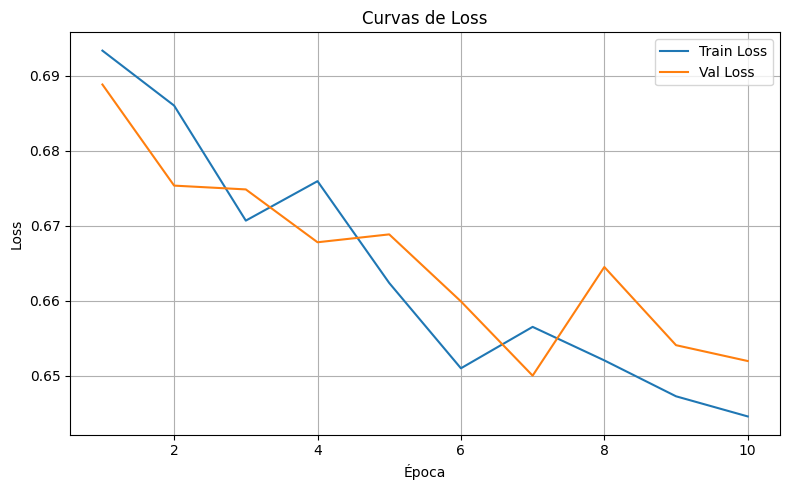

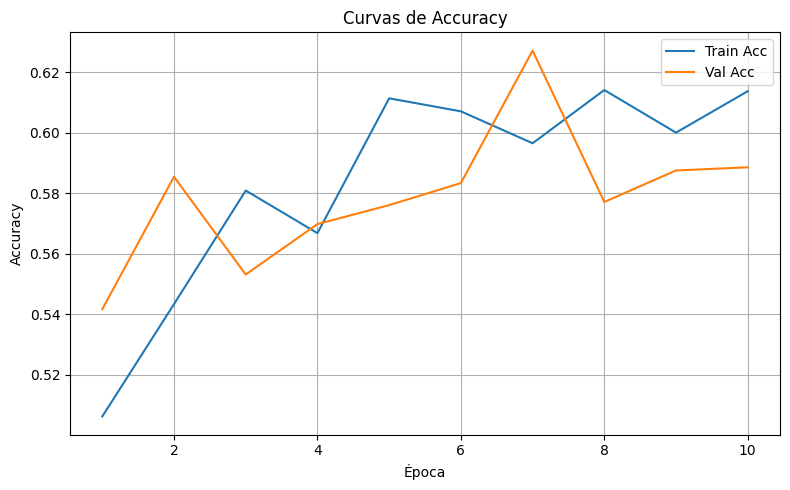

Gráficos guardados en: /content/loss_curve.png y /content/accuracy_curve.png


In [ ]:
# Registro de métricas de loss y accuracy por época
import pandas as pd
import matplotlib.pyplot as plt
from pathlib import Path

# DataFrame con las métricas
metrics_df = pd.DataFrame({
    "epoch":      list(range(1, len(history["train_loss"]) + 1)),
    "train_loss": history["train_loss"],
    "val_loss":   history["val_loss"],
    "train_acc":  history["train_acc"],
    "val_acc":    history["val_acc"],
})

# Mejor época según val_acc
best_idx = metrics_df["val_acc"].idxmax()
best_row = metrics_df.loc[best_idx]
print("Métricas por época:")
print(metrics_df.to_string(index=False, formatters={
    "train_loss": "{:.4f}".format,
    "val_loss":   "{:.4f}".format,
    "train_acc":  "{:.4f}".format,
    "val_acc":    "{:.4f}".format,
}))
print(f"\nMejor época: {int(best_row['epoch'])} | "
      f"Val Acc = {best_row['val_acc']:.4f} | Val Loss = {best_row['val_loss']:.4f}")

# CSV
out_dir = Path("/content")
csv_path = out_dir / "history_cnn_binary.csv"
metrics_df.to_csv(csv_path, index=False)
print(f"CSV guardado en: {csv_path}")

# Grafico curvas (Loss y Accuracy)
plt.figure(figsize=(8,5))
plt.plot(metrics_df["epoch"], metrics_df["train_loss"], label="Train Loss")
plt.plot(metrics_df["epoch"], metrics_df["val_loss"],   label="Val Loss")
plt.xlabel("Época"); plt.ylabel("Loss"); plt.title("Curvas de Loss"); plt.legend(); plt.grid(True)
plt.tight_layout()
loss_png = out_dir / "loss_curve.png"
plt.savefig(loss_png, dpi=120)
plt.show()

plt.figure(figsize=(8,5))
plt.plot(metrics_df["epoch"], metrics_df["train_acc"], label="Train Acc")
plt.plot(metrics_df["epoch"], metrics_df["val_acc"],   label="Val Acc")
plt.xlabel("Época"); plt.ylabel("Accuracy"); plt.title("Curvas de Accuracy"); plt.legend(); plt.grid(True)
plt.tight_layout()
acc_png = out_dir / "accuracy_curve.png"
plt.savefig(acc_png, dpi=120)
plt.show()

print(f"Gráficos guardados en: {loss_png} y {acc_png}")


📉 Curva de Loss

Los valores de loss en entrenamiento y validación van bajando de forma estable, lo que indica que el modelo está aprendiendo correctamente.
No se observa separación entre curvas, por lo que no hay sobreajuste (el modelo generaliza bien).

📈 Curva de Accuracy

La accuracy de entrenamiento y validación se mantienen cercanas y estables, subiendo levemente a lo largo de las épocas.
Esto significa que el modelo aprende de forma progresiva sin memorizar los datos → entrenamiento saludable.

## REFERENCIAS

- Material de las clases
 - Documentación oficial PyTorch: - Punto 4.1 – Modelo, capas y configuración (https://pytorch.org/docs/stable/nn.html); - Punto 4.2 – Función de pérdida y optimizador (https://pytorch.org/docs/stable/generated/torch.nn.BCEWithLogitsLoss.html y https://pytorch.org/docs/stable/optim.html) ; - Punto 4.3 – Entrenamiento y validación (https://pytorch.org/tutorials/beginner/blitz/cifar10_tutorial.html) ; Punto 4.4 – Registro de métricas (https://pytorch.org/docs/stable/generated/torch.no_grad.html)
 - Prompt en ChatGPT: Segun mis resultados, usando 15 épocas, seria mejor reducirlas a 10, para simplificar el tiempo del proceso de ejecución del codigo?

## **5. Persistencia del Modelo y Early Stopping. [Valentina Micaela Zoe Krabbe:]**
- 5.1 Modifique el bucle de entrenamiento (Consigna 4) para implementar *Early Stopping*.
    - Monitoree la *loss* de validación.
    - Defina una "paciencia" (ej. 3-5 épocas).
    - Detenga el entrenamiento si la *loss* de validación no mejora tras `N` épocas de paciencia.
- 5.2 Modifique el bucle para guardar *únicamente* los pesos del modelo (`state_dict`) que logre la **mejor *accuracy* de validación** hasta ese momento.

####**5.1 Implementacion de Early Stopping y Checkpointing**
Tomamos el bucle de entrenamiento de la consigna 4 y añadiremos la logica para detener el entrenamiento a tiempo y guardar la mejor version del modelo.

In [ ]:
#Definimos la paciencia
patience=3
#Definimos ruta para guardar el mejor state_dict
model_save_path='best_cnn_model.pth'

#Definimos variables de control para early stopping y checkpointing
best_val_loss = float('inf') #--->Inicializar con infinigo para la perdida (buscamos MIN)
best_val_acc = 0.0 #-->Inicializar con 0.0 para la presicion (buscamos MAX)
patience_counter = 0 #-->Contador de epocas sin mejora en la perdida de validacion.

#BUCLE DE ENTRENAMIENTO MODIFICO:
history = defaultdict(list) #--> Esto reinicializa el historial antes de correr

#Entrenamiento Melisa
for epoch in range(1, EPOCHS + 1):
    # ===== Entrenamiento =====
    model.train()
    tr_loss = tr_acc = 0.0
    n_tr = 0

    for b, (imgs, labels) in enumerate(train_loader, start=1):
      imgs=imgs.to(device)
      labels=labels.float().to(device)
      optimizer.zero_grad()
      logits=model(imgs).view(-1)
      loss=criterion(logits,labels)
      loss.backward()

      if GRAD_CLIP is not None:
        nn.utils.clip_grad_norm_(model.parameters(), GRAD_CLIP)

      optimizer.step()

      tr_loss += loss.item()
      tr_acc  += batch_accuracy(logits.detach(), labels.long())
      n_tr    += 1

      if MAX_TRAIN_BATCHES is not None and b >= MAX_TRAIN_BATCHES:
        break

    tr_loss /= max(n_tr, 1)
    tr_acc  /= max(n_tr, 1)

    #Validacion de Melisa
    model.eval()
    va_loss = va_acc = 0.0
    n_va = 0

    with torch.no_grad():
      for b, (imgs, labels) in enumerate(val_loader, start=1):
        imgs=imgs.to(device)
        labels=labels.float().to(device)

        logits=model(imgs).view(-1)
        loss=criterion(logits,labels)

        va_loss += loss.item()
        va_acc  += batch_accuracy(logits, labels.long())
        n_va    += 1

        if MAX_VAL_BATCHES is not None and b >= MAX_VAL_BATCHES:
          break

    va_loss /= max(n_va, 1)
    va_acc  /= max(n_va, 1)

    #5.2 Implementamos la logica de el Checkpoint - Basado en Mejor va_acc
    if va_acc > best_val_acc:
      best_val_acc=va_acc

      #Guardar solo el diccionario de estados (state_dict)
      torch.save(model.state_dict(), model_save_path)
      print(f" -> CHECKPOINT GUARDADO: Nueva mejor Acc de Validación ({best_val_acc:.4f}) en {model_save_path}")


    #Implementamos la logica de el Early Stopping - Basado en va_loss
    if va_loss < best_val_loss:
      best_val_loss = va_loss
      patience_counter = 0 #Si hubo mejora, reinicia el contador
    else:
      patience_counter += 1 #Si no hubo, incrementa la paciencia

    #Registrar metricas
    history["train_loss"].append(tr_loss)
    history["val_loss"].append(va_loss)
    history["train_acc"].append(tr_acc)
    history["val_acc"].append(va_acc)
    scheduler.step()

    #Impresion de metricas con la paciencia actual
    print(f"Epoca {epoch:02d}/{EPOCHS} | "
          f"Train Loss: {tr_loss:.4f}  Train Acc: {tr_acc:.4f} | "
          f"Val Loss: {va_loss:.4f}  Val Acc: {va_acc:.4f} | "
          f"Paciencia: {patience_counter}/{patience}")

    #Condicion de parada
    if patience_counter>=patience:
      print(f"Detenido por Early stopping- Pérdida de validacion no mejoro tras {patience} epocas")
      break

print(f"Cargando el mejor modelo guardado ({model_save_path}) para evaluacion final...")

#El modelo ahora contendra los mejores pesos alcanzados durante el entrenamiento
model.load_state_dict(torch.load(model_save_path))

/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:627: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


 -> CHECKPOINT GUARDADO: Nueva mejor Acc de Validación (0.5979) en best_cnn_model.pth
Epoca 01/10 | Train Loss: 0.6393  Train Acc: 0.6141 | Val Loss: 0.6485  Val Acc: 0.5979 | Paciencia: 0/3
 -> CHECKPOINT GUARDADO: Nueva mejor Acc de Validación (0.6052) en best_cnn_model.pth
Epoca 02/10 | Train Loss: 0.6420  Train Acc: 0.6105 | Val Loss: 0.6448  Val Acc: 0.6052 | Paciencia: 0/3
Epoca 03/10 | Train Loss: 0.6408  Train Acc: 0.6223 | Val Loss: 0.6470  Val Acc: 0.5958 | Paciencia: 1/3
Epoca 04/10 | Train Loss: 0.6466  Train Acc: 0.6023 | Val Loss: 0.6477  Val Acc: 0.6021 | Paciencia: 2/3
Epoca 05/10 | Train Loss: 0.6341  Train Acc: 0.6410 | Val Loss: 0.6473  Val Acc: 0.6010 | Paciencia: 3/3
Detenido por Early stopping- Pérdida de validacion no mejoro tras 3 epocas
Cargando el mejor modelo guardado (best_cnn_model.pth) para evaluacion final...


<All keys matched successfully>

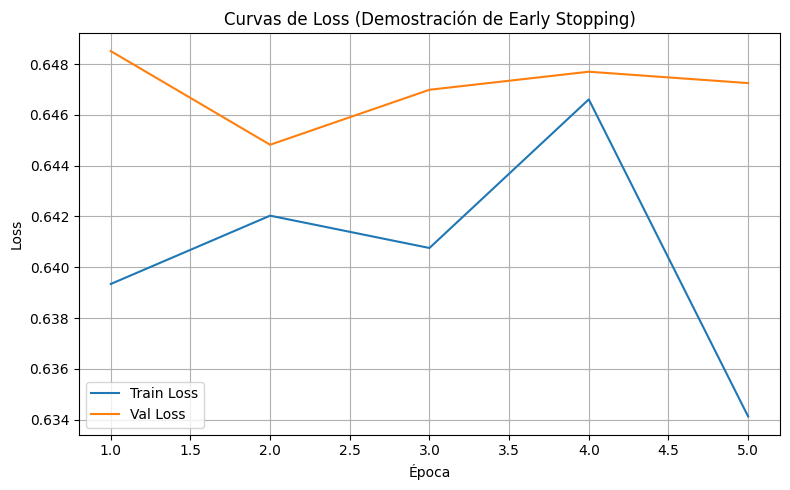

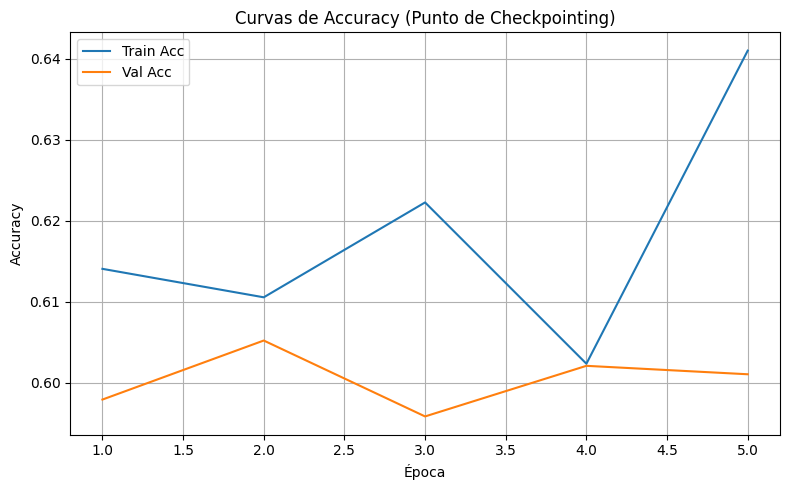

In [ ]:
metrics_df = pd.DataFrame({
    "epoch": list(range(1, len(history["train_loss"]) + 1)),
    "train_loss": history["train_loss"],
    "val_loss": history["val_loss"],
    "train_acc": history["train_acc"],
    "val_acc": history["val_acc"],
})

#Curva de loss
# Curva de Loss
plt.figure(figsize=(8,5))
plt.plot(metrics_df["epoch"], metrics_df["train_loss"], label="Train Loss")
plt.plot(metrics_df["epoch"], metrics_df["val_loss"],   label="Val Loss")
plt.xlabel("Época"); plt.ylabel("Loss"); plt.title("Curvas de Loss (Demostración de Early Stopping)"); plt.legend(); plt.grid(True)
plt.tight_layout()
loss_png = Path("/content") / "loss_curve_final.png"
plt.savefig(loss_png, dpi=120)
plt.show()

#Curva accuracy
plt.figure(figsize=(8,5))
plt.plot(metrics_df["epoch"], metrics_df["train_acc"], label="Train Acc")
plt.plot(metrics_df["epoch"], metrics_df["val_acc"],   label="Val Acc")
plt.xlabel("Época"); plt.ylabel("Accuracy"); plt.title("Curvas de Accuracy (Punto de Checkpointing)"); plt.legend(); plt.grid(True)
plt.tight_layout()
acc_png = Path("/content") / "accuracy_curve_final.png"
plt.savefig(acc_png, dpi=120)
plt.show()


Esta implementacion es para hacer el entrenamiento mas eficiente y de mejor calidad.

El **Early Stopping** hace que el modelo *"deje de entrenar cuando el modelo deja de aprender a generalizar"*. Esto ayuda a evitar el sobreajuste y ahorra tiempo al correr el codigo.

Al monitorear la **val_loss** y utilizar el contador de **patience_counter**, el modelo se detiene justo antes de que el sobreajuste sea severo, y asi garantizar que el entrenamiento es eficiente. Esto es bueno porque como no sabemos como se va a comportar el modelo en el entrenamiento, podemos gastar tiempo en epocas inutiles que le sacan eficiencia al modelo.

El **Checkpoint** asegura que, independientemente de donde finalice el entrenamiento, siempre recuperaremos la mejor version del modelo. Podemos decir que incluso si el early stopping esta activado, el mejor rendimiento del modelo tal vez pueda haber ocurrido 2 o 3 epocas antes de que el early stopping halla agotado su paciencia. Entonces si solo guardamos el modelo al final de la ultima epoca, estariamos guardando una version peor.
De esta manera al guardar el state_dict solo cuando la val_acc mejora, creamos un punto de control en el momento max del rendimiento.


Seguimos usando las 10 epocas, y con esta nueva implementacion el modelo va resgitrando las mejoras en la perdida, llego a su mejor valor de perdida en la epoca ___ y conto ___ la paciencia esperando mejoras en la perdida, como no las hubo el modelo frena en la epoca___

## **6. Evaluación y Análisis (CNN desde Cero). [Sofia Antonia Gamallo:]**
(Consigna original 4)
- 6.1 Cargue los pesos del **mejor modelo** guardado en la Consigna 5.
- 6.2 Evalúe el modelo final en el conjunto de **prueba** (test set).
- 6.3 Reporte la matriz de confusión.
- 6.4 Calcule y reporte la precisión (precision), exhaustividad (recall) y F1-score para ambas clases.
- 6.5 Visualice y analice 2-3 ejemplos de predicciones correctas e incorrectas del conjunto de prueba.

##### **6.1** Cargar los pesos del mejor modelo guardado (best_cnn_model.pth)

In [ ]:
# Cargar el mejor modelo guardado en la consigna 5
best_model_path = "best_cnn_model.pth"
model.load_state_dict(torch.load(best_model_path))
model.to(device)
model.eval()

CNNBinaryClassifier_Lite(
  (conv_layers): Sequential(
    (0): Conv2d(3, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): ReLU()
    (5): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): ReLU()
    (8): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (fc_layers): Sequential(
    (0): AdaptiveAvgPool2d(output_size=(1, 1))
    (1): Flatten(start_dim=1, end_dim=-1)
    (2): Linear(in_features=64, out_features=128, bias=True)
    (3): ReLU()
    (4): Dropout(p=0.5, inplace=False)
    (5): Linear(in_features=128, out_features=1, bias=True)
  )
)

#### **6.2** Evaluar el modelo en el conjunto de prueba

Para este punto me base en el siguiente tutorial, en el punto 5: https://docs.pytorch.org/tutorials/beginner/blitz/cifar10_tutorial.html

In [ ]:
# Listas para almacenar las etiquetas:
all_labels = []
all_preds = []

with torch.no_grad(): #esta función hace que se desactive el gradiente para poder evaluar en el test y reducir el tiempo de ejecución
    for imgs, labels in test_loader:
        imgs = imgs.to(device)
        labels = labels.to(device)

        outputs = model(imgs).view(-1)
        probs = torch.sigmoid(outputs)
        preds = (probs >= 0.5).long()

        all_labels.extend(labels.cpu().numpy())
        all_preds.extend(preds.cpu().numpy())

#### **6.3** Calcular la matriz de confusión

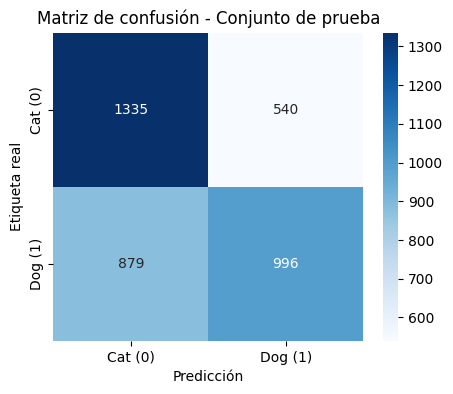

In [ ]:
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns
cm = confusion_matrix(all_labels, all_preds)
plt.figure(figsize=(5,4))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=["Cat (0)", "Dog (1)"], yticklabels=["Cat (0)", "Dog (1)"])
plt.xlabel("Predicción")
plt.ylabel("Etiqueta real")
plt.title("Matriz de confusión - Conjunto de prueba")
plt.show()

La matriz de confusión muestra una un número de errores un poco grandes:

* Verdaderos positivos: **1353** (gatos correctamente predichos)
* Verdaderos negativos: **961** (perros correctamente predichos)
* Falsos negativos: **522** (gatos predichos como perros)
* Falsos positivos: **914** (perros predichos como gatos)

El modelo predice mejor los gatos que los perros, y confunde mucho a los perros con los gatos.


#### **6.4** Evaluar el reporte de clasificación (precisión, recall, F1.score)


In [ ]:
print("Reporte de clasificación")
print(classification_report(all_labels, all_preds, target_names=["Cat", "Dog"]))

Reporte de clasificación
              precision    recall  f1-score   support

         Cat       0.60      0.71      0.65      1875
         Dog       0.65      0.53      0.58      1875

    accuracy                           0.62      3750
   macro avg       0.63      0.62      0.62      3750
weighted avg       0.63      0.62      0.62      3750



El reporte de clasificación arrojó los siguientes resultados:

* El acuraccy general del modelo es del 62%, correspondiente con los gráficos del punto 5. Es un puntaje aceptable.

* La precisión de los perros(65%) es un poco más alta que los gatos(60%). Esto quiere decir que cuando el modelo predce perro, acerta más que con los gatos.

* El recall de los gatos(72%) es bastante alto, sgnifica que el modelo detecta correctament el 72% de gatos que son reales. Sin embargo el recall de los perros(51%) baja mucho a comparación de los gatos, por lo que el modelo tiene dificultad para predecir correctamente a los perros reales.

* El F1-score (65% para gatos y 57% para perros) nos dice el porcentaje de equilirio armónico que hay entre la precisión y el recall. Nos sirve para saber si hay un desbalance de clases, que en este caso hay un sesgo hacia la clase gatos.

Como resumen, el modelo tiene un rendimiento acetable, pero se equivoca mucho al predecir perros como si fueran gatos, por eso hay un sesgo hacia la clase gatos. Este problema no viene de un desbalance de clases propio del dataset porque como se vio en el punto 1 la cantidad de etiquetas para perros y gatos son las mismas. El problema está en el modelo de la CNN, que puede mejorar con el tranfer learning próximo en el punto 8.

#### **6.5** Visualizar ejemplos de predicciones correctas e incorrectas para el conjunto de prueba

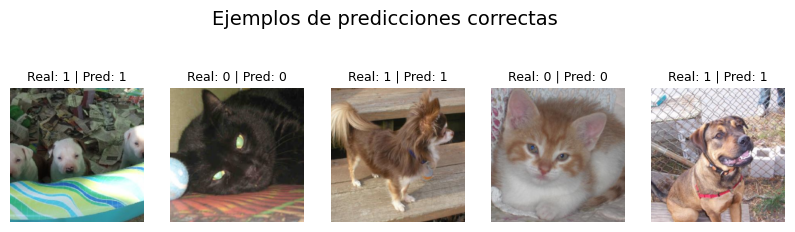

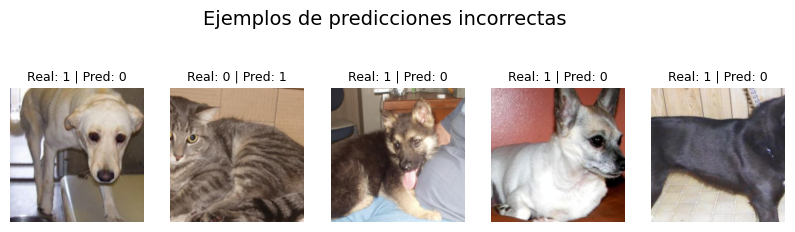

In [ ]:
correct_idx = [i for i, (p, l) in enumerate(zip(all_preds, all_labels)) if p == l]
wrong_idx   = [i for i, (p, l) in enumerate(zip(all_preds, all_labels)) if p != l]

# Convertir tensores de test_dataset en imágenes visibles
def tensor_to_img(tensor):
    img = tensor.clone().cpu().numpy().transpose(1, 2, 0)
    img = np.clip(img * np.array([0.229, 0.224, 0.225]) + np.array([0.485, 0.456, 0.406]), 0, 1)
    return img

# Mostrar algunos ejemplos correctos e incorrectos
def show_examples(indices, title, n=5):
    plt.figure(figsize=(10, 3))
    plt.suptitle(title, fontsize=14)
    for i, idx in enumerate(indices[:n]):
        img, label = test_dataset[idx]
        pred = all_preds[idx]
        plt.subplot(1, n, i+1)
        plt.imshow(tensor_to_img(img))
        plt.axis("off")
        plt.title(f"Real: {label} | Pred: {pred}", fontsize=9)
    plt.show()

show_examples(correct_idx, "Ejemplos de predicciones correctas")
show_examples(wrong_idx,   "Ejemplos de predicciones incorrectas")



> La visualización de las predicciones nos da un claro ejemplo en el sesgo del modelo hacia la predicción de gatos. Ya que hay mas perros predichos incorrectamente como gatos, que gatos predichos incorrectamente como perros.



### **Referencias:**

* Página de pytorch para realizar la evuación del modelo en el test (punto 5 del tutorial) https://docs.pytorch.org/tutorials/beginner/blitz/cifar10_tutorial.html

* Ayuda con CHAT-GPT para integrar el tutorial al trabajo y para realizar la visulización de clases del punto 6.5

## **7. Visualización de la Red (CNN desde Cero). [Erick Martinez:]**
(Consigna original 5)
- 7.1 Visualice la arquitectura de la red (por ejemplo, imprimiendo el modelo o usando `torchviz`).
- 7.2 Visualice los filtros (kernels) aprendidos en la **primera capa convolucional** del modelo.
- 7.3 Visualice los **mapas de activación** (feature maps) de al menos dos capas convolucionales intermedias para una imagen de perro y una de gato.

###  7.1 Visualice la arquitectura de la red (por ejemplo, imprimiendo el modelo o usando `torchviz`).


In [ ]:
!pip install torchviz torchsummary

📘 Arquitectura del modelo CNNBinaryClassifier_Lite:

CNNBinaryClassifier_Lite(
  (conv_layers): Sequential(
    (0): Conv2d(3, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): ReLU()
    (5): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): ReLU()
    (8): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (fc_layers): Sequential(
    (0): AdaptiveAvgPool2d(output_size=(1, 1))
    (1): Flatten(start_dim=1, end_dim=-1)
    (2): Linear(in_features=64, out_features=128, bias=True)
    (3): ReLU()
    (4): Dropout(p=0.5, inplace=False)
    (5): Linear(in_features=128, out_features=1, bias=True)
  )
)

📊 Resumen de capas (entrada 3x224x224):

------------------------

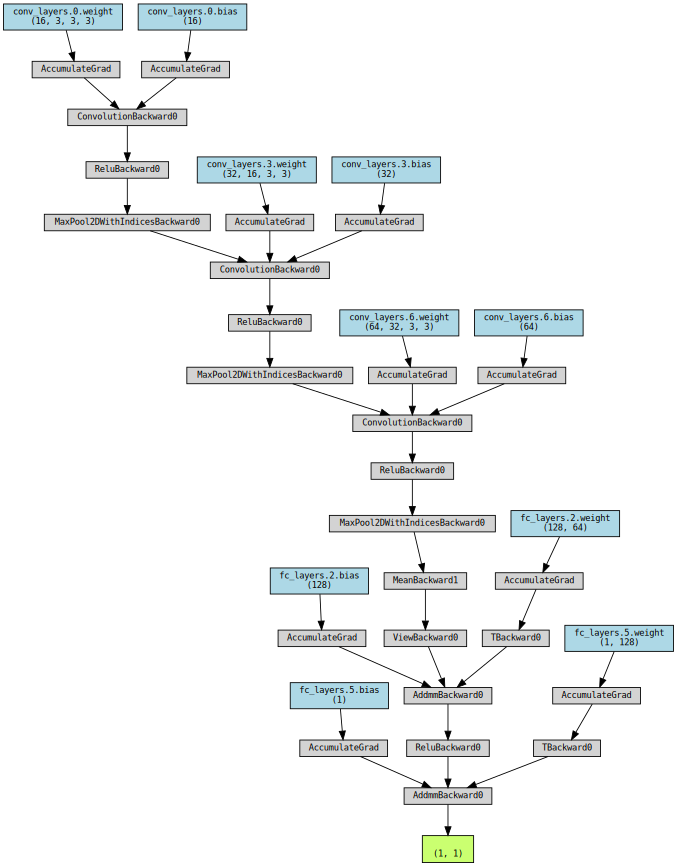

In [ ]:
from torchsummary import summary
from torchviz import make_dot
import torch

# Imprimir la estructura de la red
print("📘 Arquitectura del modelo CNNBinaryClassifier_Lite:\n")
print(model)

# Mostrar un resumen con dimensiones de cada capa
print("\n📊 Resumen de capas (entrada 3x224x224):\n")
summary(model, (3, 224, 224))

# Visualizar
x_sample = torch.randn(1, 3, 224, 224).to(device)
y_sample = model(x_sample)


from IPython.display import Image, display

dot = make_dot(y_sample, params=dict(model.named_parameters()))
dot.format = "png"

# Mostrar el grafo
display(dot)

 Esto imprimirá el modelo, un resumen de capas y generará un grafo de la red.


###  7.2 Visualice los filtros (kernels) aprendidos en la **primera capa convolucional** del modelo.

Número de filtros en la primera capa: 16
Forma de cada kernel: torch.Size([3, 3, 3])


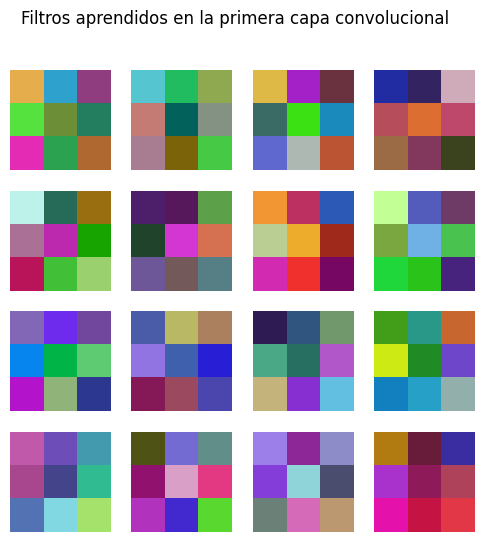

In [ ]:
import matplotlib.pyplot as plt

# Extraer la primera capa convolucional
first_conv = model.conv_layers[0]

# Obtener los pesos
kernels = first_conv.weight.data.cpu()

print(f"Número de filtros en la primera capa: {kernels.shape[0]}")
print(f"Forma de cada kernel: {kernels.shape[1:]}")

# Normalizar valores para visualización
min_k, max_k = kernels.min(), kernels.max()
kernels = (kernels - min_k) / (max_k - min_k)

# Mostrar los primeros 16 filtros
fig, axes = plt.subplots(4, 4, figsize=(6, 6))
for i, ax in enumerate(axes.flat):
    if i < kernels.shape[0]:
        img = kernels[i].permute(1, 2, 0)  # Cambiar a HWC
        ax.imshow(img)
        ax.axis("off")
plt.suptitle("Filtros aprendidos en la primera capa convolucional", fontsize=12)
plt.show()

 Este bloque muestra una cuadrícula con los filtros visualizados como imágenes RGB.

### 7.3 Visualice los **mapas de activación** (feature maps) de al menos dos capas convolucionales intermedias para una imagen de perro y una de gato.

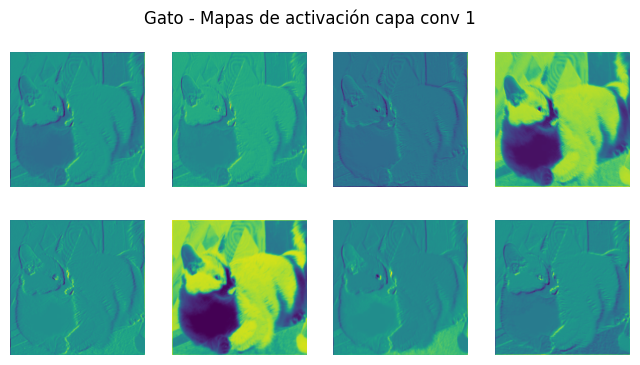

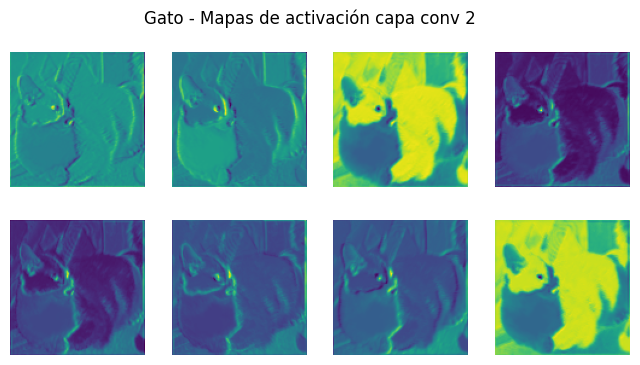

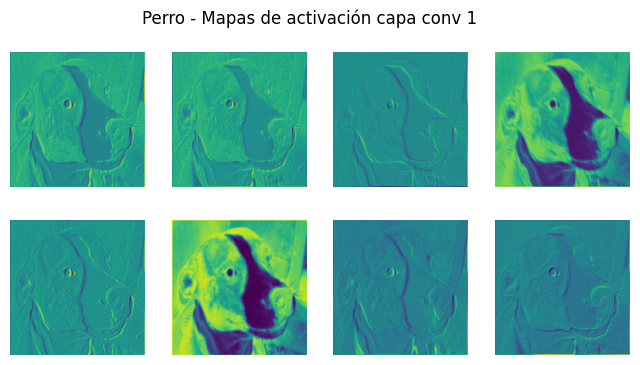

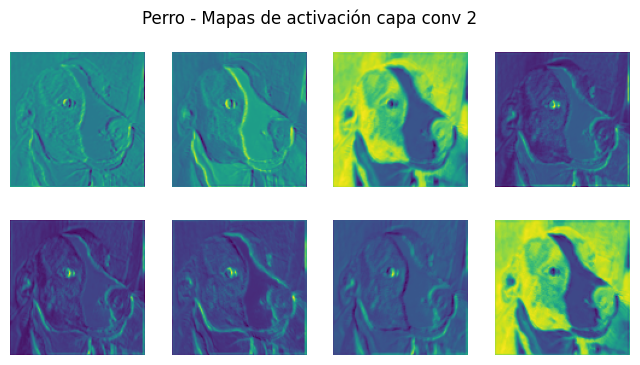

In [ ]:
import numpy as np
from torchvision import transforms
from PIL import Image

# Función para obtener las activaciones de una capa específica
def get_feature_maps(model, x, layer_indices):
    activations = []
    hooks = []

    def hook_fn(_, __, output):
        activations.append(output.detach().cpu())

    # Registrar hooks en las capas seleccionadas
    for idx in layer_indices:
        hooks.append(model.conv_layers[idx].register_forward_hook(hook_fn))

    # Forward pass
    model.eval()
    with torch.no_grad():
        _ = model(x)

    # Eliminar hooks
    for h in hooks:
        h.remove()

    return activations

# Preprocesamiento para una imagen de ejemplo
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor()
])


img_cat = Image.open(train_df[train_df['label'] == 0]['path'].iloc[0]).convert("RGB")
img_dog = Image.open(train_df[train_df['label'] == 1]['path'].iloc[0]).convert("RGB")

for img, name in [(img_cat, "Gato"), (img_dog, "Perro")]:
    x = transform(img).unsqueeze(0).to(device)
    activations = get_feature_maps(model, x, [0, 3])  # Capas convolucionales 1 y 2

    for i, act in enumerate(activations):
        fig, axes = plt.subplots(2, 4, figsize=(8, 4))
        for j, ax in enumerate(axes.flat):
            if j < act.shape[1]:
                ax.imshow(act[0, j].cpu(), cmap="viridis")
                ax.axis("off")
        plt.suptitle(f"{name} - Mapas de activación capa conv {i+1}")
        plt.show()

Este código:
Toma una imagen de gato y una de perro desde tu train_df.
Muestra los feature maps de las dos primeras capas convolucionales.
Cada figura visualiza 8 mapas (de los canales más relevantes).

### Como referencia fui explorando distintas opciones, encontre estas paginas que me sirvieron de ayuda: https://github.com/szagoruyko/pytorchviz?utm_source=chatgpt.com , https://www.geeksforgeeks.org/deep-learning/visualizing-feature-maps-using-pytorch/ y tambien utilice chat gpt para ir uniendo el codigo y que quede funcionando. Ademas del material ya visto en clases.

## **8. Implementación de Transfer Learning (Feature Extraction). [Nombre de quien resuelve:]**
- 8.1 Elija una red pre-entrenada en ImageNet (ej. `ResNet18`, `MobileNetV2` o `VGG16`).
- 8.2 Cárguela con los pesos pre-entrenados.
- 8.3 **Congele** todos los pesos de las capas convolucionales (para que no se actualicen durante el entrenamiento).
- 8.4 Reemplace la última capa (el clasificador) por una nueva capa lineal (`nn.Linear`) adecuada para nuestra clasificación binaria.

In [ ]:
# =============================================================================
# 8. Implementación de Transfer Learning (Feature Extraction)
# Nombre de quien resuelve: [TU NOMBRE]
# =============================================================================

import torch
import torch.nn as nn
from torchvision import models

# 8.1 Elegimos una red pre-entrenada: ResNet18 (ligera y muy usada)
# 8.2 Cargamos los pesos pre-entrenados en ImageNet
resnet = models.resnet18(weights=models.ResNet18_Weights.IMAGENET1K_V1)

# 8.3 Congelamos todas las capas convolucionales
for param in resnet.parameters():
    param.requires_grad = False

# 8.4 Reemplazamos la última capa (clasificador) por una nueva lineal binaria
# La capa original de ResNet18 es: model.fc = nn.Linear(512, 1000)
# La reemplazamos por una de salida única (para clasificación binaria)

num_features = resnet.fc.in_features
resnet.fc = nn.Sequential(
    nn.Linear(num_features, 128),
    nn.ReLU(),
    nn.Dropout(0.5),
    nn.Linear(128, 1)   # salida binaria (dog vs cat)
)

# Enviamos el modelo a GPU si está disponible
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
resnet = resnet.to(device)

# Verificamos que solo las capas nuevas sean entrenables
trainable_params = [name for name, param in resnet.named_parameters() if param.requires_grad]
print("Capas que se entrenarán:", trainable_params)
print(f"Total parámetros entrenables: {sum(p.numel() for p in resnet.parameters() if p.requires_grad)}")

# Prueba rápida con un batch
x, y = next(iter(train_loader))
x = x.to(device)
out = resnet(x)
print("Shape de salida:", out.shape)


Capas que se entrenarán: ['fc.0.weight', 'fc.0.bias', 'fc.3.weight', 'fc.3.bias']
Total parámetros entrenables: 65793
Shape de salida: torch.Size([32, 1])


============================================================================



## **9. Entrenamiento (Feature Extraction). [Nombre de quien resuelve:]**
- 9.1 Implemente un nuevo bucle de entrenamiento (similar a la Consigna 4).
- 9.2 Entrene el modelo de la Consigna 8. Asegúrese de que el optimizador **solo** esté actualizando los pesos de la nueva capa clasificadora que usted agregó.
- 9.3 Use los mismos `DataLoaders` (con Data Augmentation) de las consignas 1 y 2.
- 9.4 Guarde el modelo (o sus pesos) al finalizar el entrenamiento.

## **10. Ajuste Fino (Fine-Tuning). [Nombre de quien resuelve:]**
- 10.1 Tome el modelo entrenado de la Consigna 9.
- 10.2 **Descongele** las últimas capas convolucionales del modelo (ej. el último bloque de ResNet o las últimas capas de VGG).
- 10.3 Implemente un nuevo bucle de entrenamiento para re-entrenar el modelo (ahora se actualizarán tanto el clasificador como las capas descongeladas).
- 10.4 Utilice un *learning rate* **muy bajo** (ej. 10 veces más bajo que el usado en la Consigna 9) para no destruir los pesos pre-entrenados.
- 10.5 Guarde el modelo final (o sus pesos).

## **11. Evaluación Comparativa. [Nombre de quien resuelve:]**
- 11.1 Evalúe el modelo final de Fine-Tuning (Consigna 10) en el conjunto de **prueba**.
- 11.2 Calcule las mismas métricas que en la Consigna 6 (Matriz de confusión, Accuracy, Precision, Recall, F1).
- 11.3 Cree una tabla o un gráfico de barras comparando el rendimiento (Accuracy y F1-Score) del modelo "CNN desde Cero" (Consigna 6) vs. el modelo de "Fine-Tuning" (Consigna 11).








## **12. Experimentación con Optimizadores. [Nombre de quien resuelve:]**
- 12.1 Elija uno de los dos modelos (el de "CNN desde Cero" o el de "Transfer Learning").
- 12.2 Vuelva a entrenarlo (puede usar el mismo bucle de la Consigna 4 o 9), pero esta vez cambie el optimizador. Por ejemplo, si usó `Adam`, pruebe `SGD` con momento.
- 12.3 Genere un gráfico que compare las curvas de *loss* de validación del entrenamiento original vs. este nuevo entrenamiento.
- 12.4 Comente brevemente si el cambio de optimizador mejoró o empeoró la convergencia.



## **13. Visualización Avanzada (Grad-CAM). [Nombre de quien resuelve:]**
- 13.1 Investigue e implemente (o use una librería) la técnica de visualización **Grad-CAM**.
- 13.2 Aplique Grad-CAM a 2 imágenes donde el modelo "CNN desde Cero" (Consigna 6) se haya **equivocado**.
- 13.3 Aplique Grad-CAM a esas mismas 2 imágenes, pero usando el modelo de "Fine-Tuning" (Consigna 10).
- 13.4 Analice y compare los mapas de calor (heatmaps). ¿Los modelos están "mirando" lugares diferentes? ¿Ayuda esto a entender por qué uno falló y el otro (quizás) acertó?